In [1]:
# 설치되지 않은 라이브러리의 경우, 주석 해제 후 코드를 실행하여 설치
!pip install torch
!pip install pandas
!pip install tqdm
!pip install matplotlib
!pip install opencv-python
!pip install sklearn
!pip install pillow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# 필요한 라이브러리 불러오기
import os
import random
from tqdm import tqdm
import torch.nn as nn
from datetime import datetime, timezone, timedelta
import numpy as np
import torch.optim as optim
from torch.utils.data import DataLoader
import torch
import pandas as pd



In [3]:
# SEED
RANDOM_SEED = 42
torch.manual_seed(RANDOM_SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

# Set device
os.environ["CUDA_VISIBLE_DEVICES"]="0"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("GPU 사용 가능 여부 : ", torch.cuda.is_available())

# DEBUG True 설정 시, Performance recorder가 실행되지 않습니다.
DEBUG = False

# 경로 설정

### PROJECT_DIR : 코드를 실행하며 생성될 파일들이 저장될 경로 설정 ###
from google.colab import drive
drive.mount('/content/drive')

PROJECT_DIR = 'drive/MyDrive/trash_baseline_train'
ROOT_PROJECT_DIR = os.path.dirname(PROJECT_DIR)
DATA_DIR = 'drive/MyDrive/trash_baseline_train'

print("project directory 경로 전재 여부 : ", os.path.isdir(PROJECT_DIR))
print("데이터 경로가 옳은지 확인 : ", os.path.isdir(DATA_DIR))



GPU 사용 가능 여부 :  True
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
project directory 경로 전재 여부 :  True
데이터 경로가 옳은지 확인 :  True


In [4]:

MODEL = 'TrashClassifier'

# 학습 시간 (리얼 타임)에 따라 serial 생성
KST = timezone(timedelta(hours=9))
TRAIN_TIMESTAMP = datetime.now(tz=KST).strftime("%Y%m%d%H%M%S")
TRAIN_SERIAL = f'{MODEL}_{TRAIN_TIMESTAMP}' if DEBUG is not True else ''

# 학습 performance 기록 경로 설정
PERFORMANCE_RECORD_DIR = os.path.join('results', 'train', TRAIN_SERIAL)

PERFORMANCE_RECORD_COLUMN_NAME_LIST = ['train_serial', 'train_timestamp', 'model_str', 'optimizer_str', 
                                       'loss_function_str', 'metric_function_str', 'early_stopping_patience', 
                                       'batch_size', 'epoch', 'learning_rate', 'momentum', 'random_seed', 'epoch_index', 
                                       'train_loss', 'validation_loss', 'train_score', 'validation_score', 'elapsed_time']


In [5]:
# 학습 결과 저장할 폴더 만들기
def make_directory(directory: str) -> str:
    """경로가 없으면 생성
    Args:
        directory (str): 새로 만들 경로

    Returns:
        str: 상태 메시지
    """

    try:
        if not os.path.isdir(directory):
            os.makedirs(directory)
            msg = f"Directory created {directory}"

        else:
            msg = f"{directory} already exists"

    except OSError as e:
        msg = f"Fail to create directory {directory} {e}"

    return msg

make_directory(PERFORMANCE_RECORD_DIR)

'Directory created results/train/TrashClassifier_20220614141703'

In [6]:
import logging

# Set system logger
def get_logger(name: str, file_path: str, stream=False) -> logging.RootLogger:
    logger = logging.getLogger(name)
    logger.setLevel(logging.INFO)

    formatter = logging.Formatter('%(asctime)s | %(name)s | %(levelname)s | %(message)s')
    stream_handler = logging.StreamHandler()
    file_handler = logging.FileHandler(file_path)

    stream_handler.setFormatter(formatter)
    file_handler.setFormatter(formatter)

    if stream:
        logger.addHandler(stream_handler)
    logger.addHandler(file_handler)

    return logger

system_logger = get_logger(name='train', file_path=os.path.join(PERFORMANCE_RECORD_DIR, 'train_log.log'))

In [7]:
img = os.listdir(os.path.join(DATA_DIR, 'train', 'images'))
print("학습할 이미지 갯수 : ", len(img))


학습할 이미지 갯수 :  7162


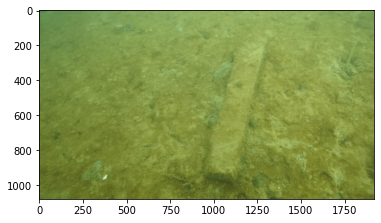

In [8]:
import matplotlib.pyplot as plt
from cv2 import cv2

sampleImage = os.path.join(DATA_DIR, 'train', 'images',img[4])


def getImg(path):
    bgr_image = cv2.imread(path)
    rgb_image = cv2.cvtColor(bgr_image, cv2.COLOR_BGR2RGB)
    return rgb_image

sampleImage = getImg(sampleImage)

plt.imshow(sampleImage)

In [9]:
train_csv = pd.read_csv(os.path.join(DATA_DIR, 'train', "train.csv"))
train_csv.sample(n=10)

,file_name,category
3337,vtxLmGV8dPf3KUb.jpg,spring fish trap
5144,v9SWyDCGOpW3lqf.jpg,tire
5062,gSBCKH1rVeUYn1I.jpg,tire
4417,SWXiPp4ukSMPEdM.jpg,tire
1615,gbhPLXw0w6ZUU6y.jpg,eel fish trap
5428,jAylYCIW9whyMTD.jpg,tire
6188,vXjxnx2J6ZMiLFA.jpg,wood
132,wQXxgICDBdSZSvK.jpg,bundle of ropes
308,XbXr5IrY7PPSiNY.jpg,bundle of ropes
5160,ecoX69b9WETIpPW.jpg,tire


In [10]:
train_csv.groupby('category').count()

,file_name
category,
bundle of ropes,417
circular fish trap,807
eel fish trap,401
fish net,564
other objects,7
rectangular fish trap,180
rope,429
spring fish trap,925
tire,1836


In [11]:
category_list = train_csv['category'].unique()
category = {}
for i in range(len(category_list)):
    category[category_list[i]] = i
print(category)

{'bundle of ropes': 0, 'circular fish trap': 1, 'eel fish trap': 2, 'rope': 3, 'fish net': 4, 'other objects': 5, 'rectangular fish trap': 6, 'tire': 7, 'spring fish trap': 8, 'wood': 9}


In [12]:
category.keys()

dict_keys(['bundle of ropes', 'circular fish trap', 'eel fish trap', 'rope', 'fish net', 'other objects', 'rectangular fish trap', 'tire', 'spring fish trap', 'wood'])

In [13]:
# 데이터로드 파라미터
BATCH_SIZE = 128
INPUT_SHAPE = (128, 128)

# 전체 학습 데이터에서 학습(train), 검증(validation) 셋으로 나눌 때, 검증 셋 비율을 설정합니다.
VAL_RATIO = 0.2

In [14]:
import os
import copy
from cv2 import cv2
import torch
import sys
from torch.utils.data import Dataset
import pandas as pd
import numpy as np
from PIL import Image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split



class CustomDataset(Dataset):
    def __init__(self, data_dir, mode, input_shape):

        # !!!!! 데이터 경로 확인 !!!!!
        self.data_dir = os.path.join(data_dir,'train')
        self.mode = mode
        self.input_shape = input_shape
        self.db = self.data_loader()
        self.transform = transforms.Compose([transforms.Resize(self.input_shape), transforms.ToTensor(), transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
        self.class_num = len(self.db['label'].unique())
        
    def data_loader(self):
        print('Loading ' + self.mode + ' dataset..')
        
        img_dir = os.path.join(self.data_dir, 'images')
        label_dir = os.path.join(self.data_dir, "train.csv")
        
        # 이미지 폴더 존재 여부 체크
        if not os.path.isdir(img_dir):
            print(f'!!! Cannot find {img_dir}... !!!')
            sys.exit()
            
        # 라벨 파일 존재 여부 체크
        if not os.path.lexists(label_dir):
            print(f'!!! Cannot find {label_dir}... !!!')
            sys.exit()
        
        category = {'bundle of ropes': 0, 'circular fish trap': 1, 'eel fish trap': 2, 
                     'rope': 3, 'fish net': 4, 'other objects': 5, 'rectangular fish trap': 6, 
                     'tire': 7, 'spring fish trap': 8, 'wood': 9}

        category_ls = list(category.keys())
        
        # train.csv를 pandas로 불러오기
        df = pd.read_csv(label_dir)
        
        # return할 train, val 데이터 초기화 - pandas dataframe 형태로 저장할 예정
        db_train = db_val = pd.DataFrame(columns=['img_path','label'])

        # 카테고리별로 train/val 비율 맞춰 나누기 위해 카테고리별로 루프 실행
        for cat in category_ls:

            img_path_list = []
            img_label_list = []
            
            # 특정 카테고리에 해당하는 이미지 리스트 뽑기
            img_list = df["file_name"].loc[df['category']==cat].values

            for filename in img_list:
                if os.path.lexists(os.path.join(img_dir, filename)):
                    img_path_list.append(os.path.join(img_dir, filename))
                    img_label_list.append(category[cat])

                else:
                    print("cannot find ", os.path.join(img_dir,filename))

                    
            db = pd.DataFrame({'img_path': img_path_list, 'label': img_label_list}) 
            
            # 학습, 검증 셋 나누기
            train, val = train_test_split(db, test_size=VAL_RATIO, random_state=42, shuffle=True)
            
            db_train = pd.concat([db_train,train])
            db_val = pd.concat([db_val,val])
 
        db_train = db_train.sample(frac=1).reset_index(drop=True)
        db_val = db_val.sample(frac=1).reset_index(drop=True)

        if self.mode=='train':
            db = db_train

        elif self.mode=='val':
            db = db_val
        else:
            print("Please check your mode : ", mode, " must be either train or val")
       
        print(db.head())
        return db

    def __len__(self):
        return len(self.db)

    def __getitem__(self, index):
        data = copy.deepcopy(self.db.loc[index])

        # 1. load image
        cvimg = cv2.imread(data['img_path'], cv2.IMREAD_COLOR | cv2.IMREAD_IGNORE_ORIENTATION)
        if not isinstance(cvimg, np.ndarray):
            raise IOError("Fail to read %s" % data['img_path'])

        # 2. preprocessing images
        trans_image = self.transform(Image.fromarray(cvimg))
        return trans_image, data['label']
    
    
# Load dataset & dataloader
train_dataset = CustomDataset(data_dir=DATA_DIR, mode='train', input_shape=INPUT_SHAPE)
validation_dataset = CustomDataset(data_dir=DATA_DIR, mode='val', input_shape=INPUT_SHAPE)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=True)

print('\nTrain set samples:',len(train_dataset),  'Val set samples:', len(validation_dataset))

Loading train dataset..
cannot find  drive/MyDrive/trash_baseline_train/train/images/0bKZDldM6gMW9sQ.jpg
cannot find  drive/MyDrive/trash_baseline_train/train/images/01oc6bd90Rwhenu.jpg
cannot find  drive/MyDrive/trash_baseline_train/train/images/0178j1q0Nd5pVk3.jpg
cannot find  drive/MyDrive/trash_baseline_train/train/images/0cOdvP9EneXGALf.jpg
cannot find  drive/MyDrive/trash_baseline_train/train/images/0BA2seqGi5QByuy.jpg
cannot find  drive/MyDrive/trash_baseline_train/train/images/0bFKKL2ToaXKqe1.jpg
cannot find  drive/MyDrive/trash_baseline_train/train/images/03JefuD2WZRq65M.jpg
cannot find  drive/MyDrive/trash_baseline_train/train/images/09vCT67EYjg5qAB.jpg
cannot find  drive/MyDrive/trash_baseline_train/train/images/0AyXUewgfDPxIgA.jpg
cannot find  drive/MyDrive/trash_baseline_train/train/images/0DZbxX3EiOJeTLj.jpg
cannot find  drive/MyDrive/trash_baseline_train/train/images/069pCvetlVly211.jpg
cannot find  drive/MyDrive/trash_baseline_train/train/images/00i0DGIW9ykDD8b.jpg
cann

In [15]:
# hyper-parameters
LEARNING_RATE = 0.0005
EPOCHS = 10

EARLY_STOPPING_PATIENCE = 10
WEIGHT_DECAY = 0.00001

OPTIMIZER = ''
SCHEDULER = ''
MOMENTUM = ''
LOSS_FN = ''
METRIC_FN = ''

In [16]:
!pip install efficientnet_pytorch
import torch
from torch import nn
from torch.nn import functional as F
from efficientnet_pytorch import EfficientNet

class TrashClassifier(nn.Module):
    def __init__(self, num_class):
        super(TrashClassifier, self).__init__()
        self.model = EfficientNet.from_pretrained('efficientnet-b0', num_classes=num_class)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, input_img):
        x = self.model(input_img)
        x = self.softmax(x)
        return x
    
# 모델 생성하기
model = TrashClassifier(num_class=train_dataset.class_num).to(device)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Loaded pretrained weights for efficientnet-b0


In [17]:
import sklearn.metrics as metrics

def get_metric_fn(y_pred, y_answer, y_prob):
    """ Metric 함수 반환하는 함수

    Returns:
        metric_fn (Callable)
    """
    assert len(y_pred) == len(y_answer), 'The size of prediction and answer are not same.'
    f1 = metrics.f1_score(y_answer, y_pred,average="macro")
    return f1, 1

# Set optimizer, scheduler, loss function, metric function, criterion (loss function)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scheduler =  optim.lr_scheduler.OneCycleLR(optimizer=optimizer, pct_start=0.1, div_factor=1e5, max_lr=0.0001, epochs=EPOCHS, steps_per_epoch=len(train_dataloader))
criterion = nn.CrossEntropyLoss()
metric_fn = get_metric_fn

In [18]:
import tqdm

class Trainer():
    """ Trainer
        epoch에 대한 학습 및 검증 절차 정의
    """

    def __init__(self, criterion, model, device, metric_fn, optimizer=None, scheduler=None, logger=None):
        """ 초기화
        """
        self.criterion = criterion
        self.model = model
        self.device = device
        self.optimizer = optimizer
        self.logger = logger
        self.scheduler = scheduler
        self.metric_fn = metric_fn

    def train_epoch(self, dataloader, epoch_index):
        """ 한 epoch에서 수행되는 학습 절차

        Args:
            dataloader (`dataloader`)
            epoch_index (int)
        """
        self.model.train()
        train_total_loss = 0
        target_lst = []
        pred_lst = []
        prob_lst = []
        for batch_index, (img, label) in enumerate(dataloader):
            
            img = img.to(self.device)
            label = label.to(self.device).long()
            pred = self.model(img)
            loss = self.criterion(pred, label)
            
            ## Pytorch에서는 gradients값들을 추후에 backward를 해줄때 계속 더해주기 때문에 
            ## 항상 backpropagation을 하기전에 gradients를 zero로 만들어주고 시작을 해야합니다.
            self.optimizer.zero_grad()
            
            loss.backward()
            self.optimizer.step()
            self.scheduler.step()
            train_total_loss += loss.item()
            prob_lst.extend(pred[:, 1].cpu().tolist())
            target_lst.extend(label.cpu().tolist())
            pred_lst.extend(pred.argmax(dim=1).cpu().tolist())
        self.train_mean_loss = train_total_loss / batch_index
        self.train_score, auroc = self.metric_fn(y_pred=pred_lst, y_answer=target_lst, y_prob=prob_lst)
        msg = f'Epoch {epoch_index}, Train loss: {self.train_mean_loss}, Acc: {self.train_score}'
        print(msg)
        #self.logger.info(msg) if self.logger else print(msg)

    def validate_epoch(self, dataloader, epoch_index, mode=None):
        """ 한 epoch에서 수행되는 검증 절차

        Args:
            dataloader (`dataloader`)
            epoch_index (int)
        """
        self.model.eval()
        val_total_loss = 0
        target_lst = []
        pred_lst = []
        prob_lst = []
        with torch.no_grad():
            for batch_index, (img, label) in enumerate(dataloader):
                img = img.to(self.device)
                label = label.to(self.device).long()
                pred = self.model(img)
                loss = self.criterion(pred, label)
                val_total_loss += loss.item()
                prob_lst.extend(pred[:, 1].cpu().tolist())
                target_lst.extend(label.cpu().tolist())
                pred_lst.extend(pred.argmax(dim=1).cpu().tolist())
            self.val_mean_loss = val_total_loss / batch_index
            self.validation_score, auroc = self.metric_fn(y_pred=pred_lst, y_answer=target_lst, y_prob=prob_lst)
            msg = f'Epoch {epoch_index}, {mode} loss: {self.val_mean_loss}, Acc: {self.validation_score}, ROC: {auroc}'
            print(msg)
        #self.logger.info(msg) if self.logger else print(msg)

        
# Set trainer
trainer = Trainer(criterion, model, device, metric_fn, optimizer, scheduler, logger=system_logger)

In [19]:
import numpy as np
import logging

class LossEarlyStopper():
    """Early stopper
    
    Attributes:
        patience (int): loss가 줄어들지 않아도 학습할 epoch 수
        verbose (bool): 로그 출력 여부, True 일 때 로그 출력
        patience_counter (int): loss 가 줄어들지 않을 때 마다 1씩 증가
        min_loss (float): 최소 loss
        stop (bool): True 일 때 학습 중단

    """

    def __init__(self, patience: int, verbose: bool, logger:logging.RootLogger=None)-> None:
        """ 초기화

        Args:
            patience (int): loss가 줄어들지 않아도 학습할 epoch 수
            weight_path (str): weight 저장경로
            verbose (bool): 로그 출력 여부, True 일 때 로그 출력
        """
        self.patience = patience
        self.verbose = verbose

        self.patience_counter = 0
        self.min_loss = np.Inf
        self.logger = logger
        self.stop = False

    def check_early_stopping(self, loss: float)-> None:
        """Early stopping 여부 판단

        Args:
            loss (float):

        Examples:
            
        Note:
            
        """  

        if self.min_loss == np.Inf:
            #첫 에폭
            self.min_loss = loss
            # self.save_checkpoint(loss=loss, model=model)

        elif loss > self.min_loss:
            # loss가 줄지 않음 -> patience_counter 1 증가
            self.patience_counter += 1
            msg = f"Early stopper, Early stopping counter {self.patience_counter}/{self.patience}"

            if self.patience_counter == self.patience:
                self.stop = True

            if self.verbose:
                self.logger.info(msg) if self.logger else print(msg)
                
        elif loss <= self.min_loss:
            # loss가 줄어듬 -> min_loss 갱신
            self.save_model = True
            msg = f"Early stopper, Validation loss decreased {self.min_loss} -> {loss}"
            self.min_loss = loss
            # self.save_checkpoint(loss=loss, model=model)

            if self.verbose:
                self.logger.info(msg) if self.logger else print(msg)
                
# Set earlystopper
early_stopper = LossEarlyStopper(patience=EARLY_STOPPING_PATIENCE, verbose=True, logger=system_logger)


In [20]:
import os
import csv
import numpy as np
import logging
from matplotlib import pyplot as plt

import torch


class PerformanceRecorder():

    def __init__(self,
                 column_name_list: list,
                 record_dir: str,
                 key_column_value_list: list,
                 model: 'model',
                 optimizer: 'optimizer',
                 scheduler: 'scheduler',
                 logger: logging.RootLogger=None):
        """Recorder 초기화
            
        Args:
            column_name_list (list(str)):
            record_dir (str):
            key_column_value_list (list)

        Note:
        """

        self.column_name_list = column_name_list
        
        self.record_dir = record_dir
        self.record_filepath = os.path.join(self.record_dir, 'record.csv')
        self.best_record_filepath = os.path.join('/'.join(self.record_dir.split('/')[:-1]),'train_best_record.csv')
        self.weight_path = os.path.join(record_dir, 'model.pt')

        self.row_counter = 0
        self.key_column_value_list = key_column_value_list

        self.train_loss_list = list()
        self.validation_loss_list= list()
        self.train_score_list = list()
        self.validation_score_list = list()

        self.loss_plot = None
        self.score_plot = None

        self.min_loss = np.Inf
        self.best_record = None

        self.logger = logger
        self.model = model
        self.optimizer = optimizer
        self.scheduler = scheduler

        self.key_column_value_list = key_column_value_list

    def set_model(self, model: 'model'):
        self.model = model

    def set_logger(self, logger: logging.RootLogger):
        self.logger = logger

    def create_record_directory(self):
        """
        record 경로 생성
        """
        make_directory(self.record_dir)
        msg = f"Create directory {self.record_dir}"
        self.logger.info(msg) if self.logger else None

    def add_row(self,
                epoch_index: int,
                train_loss: float,
                validation_loss: float,
                train_score: float,
                validation_score: float):
        """Epoch 단위 성능 적재
        
        최고 성능 Epoch 모니터링
        모든 Epoch 종료 이후 최고 성능은 train_best_records.csv 에 적재

        Args:
            row (list): 

        """
        self.train_loss_list.append(train_loss)
        self.validation_loss_list.append(validation_loss)
        self.train_score_list.append(train_score)
        self.validation_score_list.append(validation_score)

        row = self.key_column_value_list + [epoch_index, train_loss, validation_loss, train_score, validation_score]
        
        # Update scheduler learning rate
        learning_rate = self.scheduler.get_last_lr()[0]
        row[9] = learning_rate

        with open(self.record_filepath, newline='', mode='a') as f:
            writer = csv.writer(f)

            if self.row_counter == 0:
                writer.writerow(self.column_name_list)

            writer.writerow(row)
            msg = f"Write row {self.row_counter}"
            self.logger.info(msg) if self.logger else None

        self.row_counter += 1

        # Update best record & Save check point
        if validation_loss < self.min_loss:
            msg = f"Update best record row {self.row_counter}, checkpoints {self.min_loss} -> {validation_loss}"
            
            self.min_loss = validation_loss
            self.best_record = row
            self.save_weight()

            self.logger.info(msg) if self.logger else None

    def add_best_row(self):
        """
        모든 Epoch 종료 이후 최고 성능에 해당하는 row을 train_best_records.csv 에 적재
        """

        n_row = count_csv_row(self.best_record_filepath)

        with open(self.best_record_filepath, newline='', mode='a') as f:
            writer = csv.writer(f)

            if n_row == 0:
               writer.writerow(self.column_name_list)
            
            writer.writerow(self.best_record)

        msg = f"Save best record {self.best_record_filepath}"
        self.logger.info(msg) if self.logger else None

    def save_weight(self)-> None:
        """Weight 저장

        Args:
            loss (float): validation loss
            model (`model`): model
        
        """
        check_point = {
            'model': self.model.state_dict(),
            'optimizer': self.optimizer.state_dict(),
            'scheduler': self.scheduler.state_dict()
        }
        torch.save(check_point, self.weight_path)
        #torch.save(self.model.state_dict(), self.weight_path)
        msg = f"Model saved: {self.weight_path}"
        self.logger.info(msg) if self.logger else None

    def save_performance_plot(self, final_epoch: int):
        """Epoch 단위 loss, score plot 생성 후 저장

        """
        self.loss_plot = self.plot_performance(epoch=final_epoch+1,
                                          train_history=self.train_loss_list,
                                          validation_history=self.validation_loss_list,
                                          target='loss')
        self.score_plot = self.plot_performance(epoch=final_epoch+1,
                                           train_history=self.train_score_list,
                                           validation_history=self.validation_score_list,
                                           target='score')

        self.loss_plot.savefig(os.path.join(self.record_dir, 'loss.png'))
        self.score_plot.savefig(os.path.join(self.record_dir, 'score.jpg'))
        plt.close('all')


        msg = f"Save performance plot {self.record_dir}"
        self.logger.info(msg) if self.logger else None

    def plot_performance(self,
                         epoch: int,
                         train_history:list,
                         validation_history:list,
                         target:str)-> plt.figure:
        """loss, score plot 생성

        """
        fig = plt.figure(figsize=(12, 5))
        epoch_range = list(range(epoch))

        plt.plot(epoch_range, train_history, marker='.', c='red', label="train")
        plt.plot(epoch_range, validation_history, marker='.', c='blue', label="validation")

        plt.legend(loc='upper right')
        plt.grid()
        plt.xlabel('epoch')
        plt.ylabel(target)

        return fig

In [21]:
key_column_value_list = [
    TRAIN_SERIAL,
    TRAIN_TIMESTAMP,
    MODEL,
    OPTIMIZER,
    LOSS_FN,
    METRIC_FN,
    EARLY_STOPPING_PATIENCE,
    BATCH_SIZE,
    EPOCHS,
    LEARNING_RATE,
    WEIGHT_DECAY,
    RANDOM_SEED]

performance_recorder = PerformanceRecorder(column_name_list=PERFORMANCE_RECORD_COLUMN_NAME_LIST,
                                           record_dir=PERFORMANCE_RECORD_DIR,
                                           key_column_value_list=key_column_value_list,
                                           logger=system_logger,
                                           model=model,
                                           optimizer=optimizer,
                                           scheduler=scheduler)


In [22]:
from tqdm import tqdm

criterion = 1E+8

# 저장될 모델 이름
model_name = 'best.pt'

# 에폭 별로 train_epoch, valid_epoch 실헹힘
for epoch_index in tqdm(range(EPOCHS)):

    trainer.train_epoch(train_dataloader, epoch_index)
    trainer.validate_epoch(validation_dataloader, epoch_index, 'val')

    # Performance record - csv & save elapsed_time
    performance_recorder.add_row(epoch_index=epoch_index,
                                 train_loss=trainer.train_mean_loss,
                                 validation_loss=trainer.val_mean_loss,
                                 train_score=trainer.train_score,
                                 validation_score=trainer.validation_score)

    # Performance record - plot
    performance_recorder.save_performance_plot(final_epoch=epoch_index)

    # early_stopping check
    early_stopper.check_early_stopping(loss=trainer.val_mean_loss)

    if early_stopper.stop:
        print('Early stopped')
        break
    
    if trainer.val_mean_loss < criterion:
        criterion = trainer.val_mean_loss
        performance_recorder.weight_path = os.path.join(PERFORMANCE_RECORD_DIR, model_name)
        performance_recorder.save_weight()
        # print(f'{epoch_index} model saved train acc :{trainer.train_score}, val acc :{trainer.validation_score}')
        print(f'{epoch_index} model saved')
        print('----------------------------------')


print("Model saved: ", os.path.join(PERFORMANCE_RECORD_DIR, model_name))
print("Train score saved: ",os.path.join(PERFORMANCE_RECORD_DIR, 'score.jpg'))
print("Train loss saved: ",os.path.join(PERFORMANCE_RECORD_DIR, 'loss.png'))

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0, Train loss: 2.3262164267626675, Acc: 0.18448423826456672
Epoch 0, val loss: 2.2962750738317315, Acc: 0.3505439644081985, ROC: 1


 10%|█         | 1/10 [05:15<47:23, 315.96s/it]

0 model saved
----------------------------------
Epoch 1, Train loss: 1.9683202803134918, Acc: 0.44082900416617987
Epoch 1, val loss: 1.9177349372343584, Acc: 0.3566984194488597, ROC: 1


 20%|██        | 2/10 [09:53<39:04, 293.12s/it]

1 model saved
----------------------------------
Epoch 2, Train loss: 1.748018890619278, Acc: 0.594513603329369
Epoch 2, val loss: 1.8094190900976008, Acc: 0.5994305899320662, ROC: 1


 30%|███       | 3/10 [14:22<32:56, 282.38s/it]

2 model saved
----------------------------------
Epoch 3, Train loss: 1.652334064245224, Acc: 0.7197661840272102
Epoch 3, val loss: 1.74470853805542, Acc: 0.7482091635307923, ROC: 1


 40%|████      | 4/10 [18:45<27:27, 274.54s/it]

3 model saved
----------------------------------
Epoch 4, Train loss: 1.59686171466654, Acc: 0.7920444374499032
Epoch 4, val loss: 1.7051832242445513, Acc: 0.7868173984671624, ROC: 1


 50%|█████     | 5/10 [23:09<22:33, 270.79s/it]

4 model saved
----------------------------------
Epoch 5, Train loss: 1.5735925788229161, Acc: 0.8129399321961472
Epoch 5, val loss: 1.7003881497816606, Acc: 0.809030683891771, ROC: 1


 60%|██████    | 6/10 [27:30<17:49, 267.48s/it]

5 model saved
----------------------------------
Epoch 6, Train loss: 1.5620819519866596, Acc: 0.8261879792342091
Epoch 6, val loss: 1.6808850114995784, Acc: 0.8155871815505329, ROC: 1


 70%|███████   | 7/10 [31:54<13:19, 266.53s/it]

6 model saved
----------------------------------
Epoch 7, Train loss: 1.5579656714742833, Acc: 0.8325426550576402
Epoch 7, val loss: 1.675130464813926, Acc: 0.8191477797302298, ROC: 1


 80%|████████  | 8/10 [36:18<08:50, 265.49s/it]

7 model saved
----------------------------------
Epoch 8, Train loss: 1.5506085076115348, Acc: 0.8403504455597893


 90%|█████████ | 9/10 [40:48<04:26, 266.91s/it]

Epoch 8, val loss: 1.676072196526961, Acc: 0.8199415864997104, ROC: 1
Epoch 9, Train loss: 1.552460865540938, Acc: 0.8398463303306782
Epoch 9, val loss: 1.6747680468992754, Acc: 0.8213249117543657, ROC: 1


100%|██████████| 10/10 [45:21<00:00, 272.11s/it]

9 model saved
----------------------------------
Model saved:  results/train/TrashClassifier_20220614141703/best.pt
Train score saved:  results/train/TrashClassifier_20220614141703/score.jpg
Train loss saved:  results/train/TrashClassifier_20220614141703/loss.png
